In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017)
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D, AveragePooling2D, SeparableConv2D, Conv2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.merge import concatenate
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Activation, merge


In [3]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 9s 0us/step


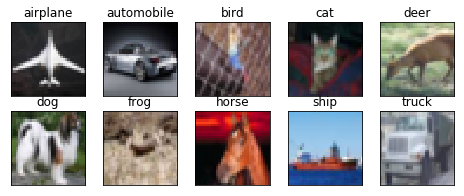

In [4]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [8]:
train_labels.shape
train_features.shape

(50000, 32, 32, 3)

In [0]:
shape_of_image = (32,32)+(3,)
input_image_shape = Input(shape = input_shape)

In [18]:
Input(shape = input_shape)

<tf.Tensor 'input_2:0' shape=(?, 32, 32, 3) dtype=float32>

In [66]:
#Normal covolution

x = Convolution2D(32,3,border_mode='same')(input_image_shape)  #(3x3,32x32)
x = BatchNormalization(axis = 3)(x)
x = Activation('relu')(x)
x = Dropout(0.1)(x)

# 1st Spatially Seperable Convolution
x = Conv2D(32,kernel_size=(3,1),strides=1,padding = 'same',data_format='channels_last')(x)
x = BatchNormalization(axis = 3)(x)
x = Activation('relu')(x)
x = Dropout(0.1)(x)

# 2nd Spatially Seperable Convolution
x = Conv2D(64,kernel_size=(1,3),strides=1,padding = 'same',data_format='channels_last')(x) #(5x5,32x32)
x = BatchNormalization(axis = 3)(x)
x = Activation('relu')(x)
x = Dropout(0.1)(x)

# Depthwise Separable Convolution 
x = SeparableConv2D(64,3,strides=1,padding='same',data_format='channels_last')(x)#(7x7,32x32)
x = BatchNormalization(axis = 3)(x)
x = Activation('relu')(x)
x = Dropout(0.1)(x)



# Reducing channel size with 1x1 and maxpooling to reduce image size
x = Convolution2D(32, 1,strides=1,data_format='channels_last' )(x) #(7x7,32x32)
x = BatchNormalization(axis = 3)(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2,2),data_format='channels_last')(x) #(14x14,16x16)
x = Dropout(0.1)(x)

# Grouped Convolution (use 3x3, 5x5 only)(overall 5x5 with two 3x3)
x = Conv2D(64,3,strides=1,padding='same',data_format='channels_last')(x) #(16x16,16x16)
x = BatchNormalization(axis = 3)(x)
x = Activation('relu')(x)
x = Dropout(0.1)(x)

skip_tensor = x

x = Conv2D(128,3,strides=1,padding = 'same',data_format='channels_last')(x) #(18x18,16x16)
x = BatchNormalization(axis = 3)(x)
x = Activation('relu')(x)
x = Dropout(0.1)(x)

x = concatenate([skip_tensor, x])

# Reducing channel size with 1x1 and maxpooling to reduce image size 
x = Conv2D(32,1,strides=1,data_format='channels_last')(x) #(18x18,16x16)
x = BatchNormalization(axis = 3)(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2,2),data_format='channels_last')(x) #(32x32,8x8)
x = Dropout(0.1)(x)                
 
#  Grouped Convolution (use 3x3 only, two with dilation = 1, and another with dilation = 2) 
x = Conv2D(32,3,strides=1,padding='same',data_format='channels_last',dilation_rate = 1)(x) #(34x34,8x8)
x = BatchNormalization(axis = 3)(x)
x = Activation('relu')(x)
x = Dropout(0.1)(x)

x = Conv2D(32,3,strides=1,padding='same',data_format='channels_last',dilation_rate = 1)(x) #(36x36,8x8)
x = BatchNormalization(axis = 3)(x)
x = Activation('relu')(x)
x = Dropout(0.1)(x)

skip_tensor = x
  
x = Conv2D(64,3,strides=1,padding='same',data_format='channels_last',dilation_rate = 2)(x) #(38x38,8x8)
x = BatchNormalization(axis = 3)(x)
x = Activation('relu')(x)  
x = Dropout(0.1)(x)

x = concatenate([skip_tensor, x])

x = Conv2D(10, 1,strides=1,data_format='channels_last')(x) #(38x38,8x8)
x = BatchNormalization(axis = 3)(x)
x = Activation('relu')(x)
x = Dropout(0.1)(x)



x = Conv2D(num_classes,(8,8))(x) #(45x45,1x1)
x = Flatten()(x)
output = Activation('softmax')(x)
                



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, 3, padding="same")`
  


In [0]:
model = Model(inputs=img_input, outputs=output)

In [68]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_75 (Conv2D)              (None, 32, 32, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_82 (BatchNo (None, 32, 32, 32)   128         conv2d_75[0][0]                  
__________________________________________________________________________________________________
activation_75 (Activation)      (None, 32, 32, 32)   0           batch_normalization_82[0][0]     
__________________________________________________________________________________________________
dropout_70

In [0]:
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [0]:
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
def scheduler(epoch, lr):
  return round(0.003 * 1/(1 + 0.319 * epoch), 10)

callback = [LearningRateScheduler(scheduler, verbose=1)]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, callbacks=[<keras.ca..., steps_per_epoch=195, epochs=50)`
  if __name__ == '__main__':


Epoch 1/50


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '



Epoch 00001: LearningRateScheduler setting learning rate to 0.003.
195/195 [==============================] - 29s 147ms/step - loss: 1.5433 - acc: 0.4365 - val_loss: 1.7917 - val_acc: 0.4356
Epoch 2/50

Epoch 00002: LearningRateScheduler setting learning rate to 0.0022744503.
195/195 [==============================] - 21s 108ms/step - loss: 1.0890 - acc: 0.6090 - val_loss: 1.1715 - val_acc: 0.6012
Epoch 3/50

Epoch 00003: LearningRateScheduler setting learning rate to 0.0018315018.
195/195 [==============================] - 21s 108ms/step - loss: 0.9169 - acc: 0.6715 - val_loss: 1.0983 - val_acc: 0.6020
Epoch 4/50

Epoch 00004: LearningRateScheduler setting learning rate to 0.0015329586.
195/195 [==============================] - 21s 107ms/step - loss: 0.8118 - acc: 0.7094 - val_loss: 0.8225 - val_acc: 0.7112
Epoch 5/50

Epoch 00005: LearningRateScheduler setting learning rate to 0.0013181019.
195/195 [==============================] - 21s 108ms/step - loss: 0.7421 - acc: 0.7368 - val

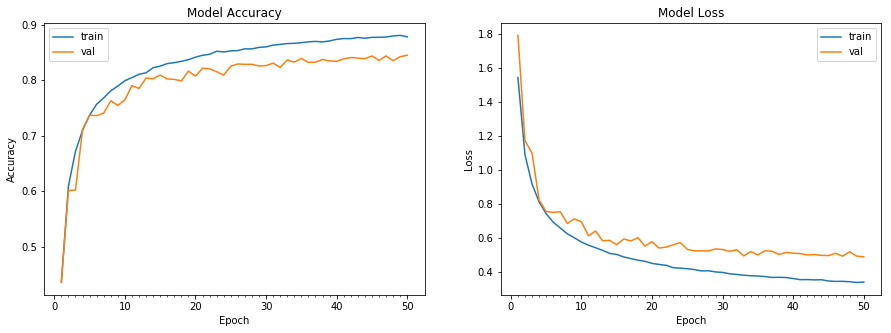

Accuracy on test data is: 84.48


In [71]:
datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,data_format='channels_last')


# Training model
start = time.time()

model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 256),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels), verbose=1,callbacks = callback )
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))